### Plot activation functions

In [42]:
include("../code/activation.jl")

x = -3:0.01:3
y_sigmoid = sigmoid.(x)
y_relu = relu.(x)
y_lrelu = leaky_relu.(x, 0.1)
plot(x, y_sigmoid, label="Sigmoid")
plot!(x, y_relu, label="ReLU")
plot!(x, y_lrelu, label="Leaky ReLU")

savefig("activation_functions.pdf")

"c:\\Users\\danfy\\Documents\\Projects\\fys-stk4155\\project_2\\calc\\activation_functions.pdf"

### FFNN hypertuning

##### Grid search

Note that grid search can be very slow on single thread.

In [ ]:
include("../code/hypertuning.jl")
include("../code/franke.jl")
include("../code/activation.jl")

Random.seed!(0)

n_samples = 1000
noise_amplitude = 0.01
random_inputs = false

X, y = franke_training_data(n_samples, noise_amplitude, random_inputs)
X_scaled = standardize_data(X)
Y = reshape(y, (length(y), 1))

hidden_layers = hidden_layer_configs(3, 3, 7)

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
l2_lambdas = [0.0, 0.0001, 0.001, 0.01]

mse(y_pred, y_true) = mean((y_pred .- y_true) .^ 2)
mse_prime(y_pred, y_true) = y_pred .- y_true

model_functions = NetworkFunctions(
  sigmoid,
  sigmoid_prime,
  lin,
  lin_prime,
  mse,
  mse_prime
)

best_params, all_results = grid_search(
  X_scaled, Y,
  hidden_layers,
  learning_rates,
  l2_lambdas,
  model_functions,
  k_folds=5,
  epochs=100,
  batch_size=32,
  verbose=true,
)

final_plot, best_results = create_tuning_visualizations(all_results)
display(final_plot)
println(best_results)

##### Random search

Layers: [2, 32, 64, 1], LR: 1.88e-02, L2: 1.10e-06
MSE: 2.79e-02 (±3.03e-03)
R2: 6.63e-01 (±3.48e-02)
Time: 5.14e-01 (±4.02e-01)

Layers: [2, 8, 8, 1], LR: 4.38e-02, L2: 3.45e-06
MSE: 2.53e-02 (±2.70e-03)
R2: 6.93e-01 (±1.08e-02)
Time: 8.57e-02 (±2.30e-03)

Layers: [2, 4, 1], LR: 1.32e-02, L2: 3.16e-05
MSE: 2.42e-02 (±4.25e-03)
R2: 7.07e-01 (±4.26e-02)
Time: 4.31e-02 (±1.75e-02)

Layers: [2, 64, 1], LR: 2.69e-02, L2: 4.77e-04
MSE: 2.20e-02 (±3.26e-03)
R2: 7.33e-01 (±4.09e-02)
Time: 1.71e-01 (±8.92e-04)

Layers: [2, 16, 1], LR: 8.33e-02, L2: 6.12e-06
MSE: 2.01e-02 (±7.34e-03)
R2: 7.59e-01 (±7.75e-02)
Time: 1.03e-01 (±1.64e-02)

Layers: [2, 64, 32, 1], LR: 8.60e-02, L2: 1.16e-04
MSE: 1.98e-02 (±2.62e-03)
R2: 7.57e-01 (±4.76e-02)
Time: 3.06e-01 (±5.09e-03)

Layers: [2, 128, 8, 1], LR: 7.95e-02, L2: 4.42e-05
MSE: 1.37e-02 (±2.74e-03)
R2: 8.35e-01 (±2.13e-02)
Time: 5.25e-01 (±5.09e-02)



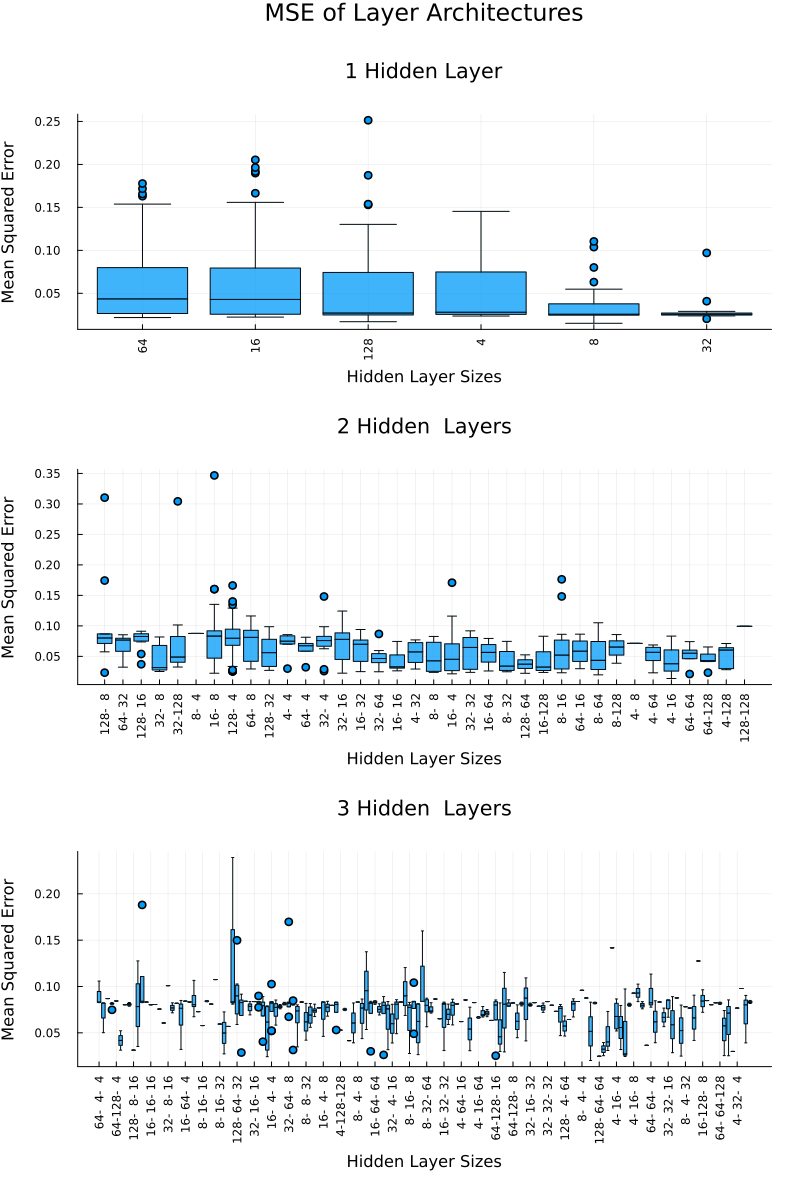

In [ ]:
include("../code/hypertuning.jl")
include("../code/franke.jl")
include("../code/activation.jl")

using Plots

Random.seed!(0)

n_samples = 1000
noise_amplitude = 0.01
random_inputs = false

X, y = franke_training_data(n_samples, noise_amplitude, random_inputs)
X_scaled = standardize_data(X)
Y = reshape(y, (length(y), 1))

mse(y_pred, y_true) = mean((y_pred .- y_true) .^ 2)
mse_prime(y_pred, y_true) = (y_pred .- y_true) ./ length(y_true)

model_functions = NetworkFunctions(
  sigmoid,
  sigmoid_prime,
  lin,
  lin_prime,
  mse,
  mse_prime
)

best_params, all_results = random_search(
  X_scaled, Y,
  model_functions,
  k_folds=5,
  epochs=100,
  batch_size=32,
  trials=1000,
  verbose=true
)

final_plot, best_results = visualize_architecture_tuning(all_results)
display(final_plot)
#println(best_results)

#### Comparison to OLS and Ridge Regression

In [ ]:
include("../code/activation.jl")
include("../code/cost.jl")
include("../code/franke.jl")
include("../code/neural_network.jl")
include("../code/hypertuning.jl")
include("../code/regression.jl")
include("../code/utils.jl")

using DataFrames
using DataStructures
using Random

Random.seed!(0)

data = Vector{RegressionModelScore}()

# Generate data
n_samples = 1000
noise_amplitude = 0.01
random_inputs = false

X, y = franke_training_data(n_samples, noise_amplitude, random_inputs)
X_scaled = standardize_data(X)
Y = reshape(y, (length(y), 1))

# Evaluate FFNN
layer_sizes = [2, 32, 16, 1]
lr = 0.001
l2_lambda = 1e-4

k_folds = 10
n_epochs = 1000
batch_size = 32

ffnn_models = OrderedDict(
  "FFNN (sigmoid)" => (sigmoid, sigmoid_prime),
  "FFNN (ReLU)" => (relu, relu_prime),
  "FFNN (LReLU)" => (leaky_relu, leaky_relu_prime)
)

for (model_name, (activation, activation_prime)) in ffnn_models
  model = initialize_network(
    layer_sizes,
    activation, activation_prime,
    lin, lin_prime,
    mse, mse_prime,
    ConstantLR(lr),
    l2_lambda
  )

  mse_ffnn, r2_ffnn, time_ffnn =
    evaluate_network(X_scaled, Y, model, k_folds, n_epochs, batch_size)
  ffnn_score = network_scores(model_name, mse_ffnn, r2_ffnn, time_ffnn)
  push!(data, ffnn_score)
end

# Evaluate Flux models
flux_models = OrderedDict(
  "Flux FFNN (sigmoid)" => (sigmoid, nothing),
  "Flux FFNN (ReLU)" => (relu, nothing),
  "Flux FFNN (LReLU)" => (leaky_relu, nothing)
)

for (model_name, (hidden_activation, output_activation)) in flux_models
  mse_flux, r2_flux, time_flux = evaluate_flux(
    X_scaled, Y,
    layer_sizes,
    hidden_activation, output_activation,
    lr, l2_lambda,
    k_folds,
    n_epochs,
    batch_size,
  )
  flux_score = network_scores(model_name, mse_flux, r2_flux, time_flux)
  push!(data, flux_score)
end

# Evaluate linear models
linear_models = OrderedDict(
  "OLS" => (ordinary_least_squares, 0.0),
  "Ridge" => (ridge_regression, l2_lambda),
)
degrees = 0:20
for (model_name, (regression_model, reg_param)) in linear_models
  mse_linear, r2_linear, time_linear = evaluate_regression_model(
    X_scaled, y,
    degrees=degrees,
    k_folds=k_folds,
    regression_model=regression_model,
    λ=reg_param
  )
  linear_score = regression_scores(model_name, mse_linear, r2_linear, time_linear, degrees)
  push!(data, linear_score)
end

df = DataFrame(
  model=[d.model for d in data],
  mse=[d.mse_mean_std[1] for d in data],
  mse_std=[d.mse_mean_std[2] for d in data],
  r2=[d.r2_mean_std[1] for d in data],
  r2_std=[d.r2_mean_std[2] for d in data],
  time=[d.time_mean_std[1] for d in data],
  time_std=[d.time_mean_std[2] for d in data],
)

display(df)
headers = OrderedDict{String,Union{Symbol,Tuple{Symbol,Symbol}}}(
  "Model" => :model,
  "MSE" => (:mse, :mse_std),
  "R^2" => (:r2, :r2_std),
  "Time [s]" => (:time, :time_std),
)

markdown_table = dataframe_to_markdown_table(df, headers)
open("regression_models_table.txt", "w") do io
  write(io, markdown_table)
end


Row,model,mse,mse_std,r2,r2_std,time,time_std
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,FFNN (sigmoid),0.00414594,0.00257947,0.950685,0.0284124,1.75813,0.369005
2,FFNN (ReLU),0.000447231,0.000148439,0.994572,0.00149289,0.857187,0.122216
3,FFNN (LReLU),0.000395421,0.000239486,0.995259,0.00243664,0.813173,0.0780774
4,Flux FFNN (sigmoid),0.0791942,0.012987,0.0265434,0.0382798,10.7369,0.993115
5,Flux FFNN (ReLU),0.0764065,0.00791016,0.077082,0.0325585,10.5272,0.256108
6,Flux FFNN (LReLU),0.0758054,0.0120343,0.0711837,0.0418728,11.1437,0.508254
7,OLS (p=14),0.000162565,4.26764e-5,0.997964,0.000539112,0.015995,0.00206909
8,Ridge (p=15),0.00016115,6.55214e-5,0.998031,0.000754225,0.0161149,0.00130614


1073